#**Time dependent PDE**
\begin{align}
\frac{\partial u}{\partial t}-\Delta u = f, \quad & \text{in } \Omega\times (0,T], \\
u = u_C, \quad & \text{on }  \Gamma_C\times (0,T], \\
u = u_L, \quad & \text{on }  \Gamma_L\times (0,T], \\
\nabla u \cdot \mathbf{n} = h, \quad & \text{on }  \Gamma_N\times (0,T], \\
u(0) = u_0, \quad & \text{at } t = 0,
\end{align}
where:
- $T=8$ and $u_0=0$;
- the domain $\Omega$ is the rectangle $[0,0]\times[10,5]$ with a hole on the circle of radius $r=1.5$ centered in $C=(7,2.5)$;
- $\Gamma_C$ is the circle boundary;
- $\Gamma_L$ is the left edge of the rectangle;
- $\Gamma_N=\partial\Omega \setminus\{\Gamma_C\cup \Gamma_L\}$ is the rest of the rectangle boundary;
- $u_L=\alpha \, (5y-y^2) \, (1- \sin(2\pi t)\,e^{-t})$, with $\alpha=1$;
- $u_C=\beta \sin(\pi t)\,e^{-t}$, with $\beta=-5$;
- $h=\gamma$, with $\gamma=0$;
- $f=0$.
-Linear Finite Element for the space discretization and the Implicit Euler method with a timestep $\Delta t = 0.05$ for the time discretization.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    import dolfin as df
    import mshr
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin as df
    import mshr

# import numpy as np and pyplot as plt.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# clear the long output of the fenics installation
from IPython.display import clear_output 
clear_output()

In [ ]:
#Coefficients and functions
alpha = 1
beta = -5
gamma = 0
T = 8
dt = 0.05
time_steps=int(T/dt)
h = df.Constant(gamma)
f = df.Constant(0)

In [ ]:
#Domain and mesh
rectangle = mshr.Rectangle(df.Point(0,0),df.Point(10,5))
circle = mshr.Circle(df.Point(7,2.5),1.5)
domain = rectangle - circle
mesh = mshr.generate_mesh(domain,15)
#df.plot(mesh)

In [ ]:
#Finite element space
V = df.FunctionSpace(mesh,'P',1)

In [ ]:
#Intial condition
u0 = df.Constant(0)
uk = df.interpolate(u0,V)

In [ ]:
#Boundary conditions
pi = df.pi
uL = df.Expression('a*(5*x[1]-x[1]*x[1]) * (1-sin(2*pi*t)*exp(-t))', degree=3, a=alpha, t=0)
uC = df.Expression('b*sin(pi*t)*exp(-t)', degree=3, b=beta, t=0)
#Left edge of the rectangle - GammaL
def boundaryL (x, on_boundary):
  return on_boundary and df.near(x[0],0,1e-14)
bcL = df.DirichletBC(V, uL, boundaryL)

#edge of the circle - GammaC
def boundaryC (x, on_boundary):
  return on_boundary and x[0]>5.5 and x[0]<8.5 and x[1]>1 and x[1]<4
bcC = df.DirichletBC(V, uC, boundaryC)

In [ ]:
#Weak formulation
u = df.TrialFunction(V)
v = df.TestFunction(V)
b = (u/dt)*v *df.dx + (df.dot(df.grad(u),df.grad(v)) * df.dx)
G = (uk/dt)*v *df.dx + h*v *df.ds

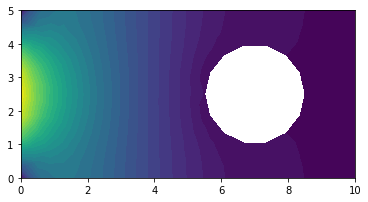

In [ ]:
#solution
vtkfile = df.File('/content/drive/MyDrive/Colab Notebooks/Functional analysis and numerics for PDEs/Paraview Solutions/Lab 04/Time dependent PDE/Solution.pvd')

u = df.Function(V)
t=0

for k in range(time_steps):
  t = t+dt
  uL.t = t
  uC.t = t
  df.solve(b==G, u, [bcL,bcC])
  vtkfile << (u,t)
  uk.assign(u)

df.plot(u) #plot the solution for t =T

#**Poisson problem with imported mesh**

$$-\Delta u = f, \quad \text{in } \Omega \\ u = u_D, \quad \text{on } \partial \Omega $$

where:
- the source term is a constant: $f = 0$;
- the exact solution (used also as the Dirichlet BC $u_D$) is known: $u_{ex} = 1+x^2+2y^2$ 

In [ ]:
import os

def download_if_not_exists(filename):
  if not os.path.exists(filename):
    !wget https://fenicsproject.org/pub/data/meshes/$filename

# 3D meshes
download_if_not_exists('aneurysm.xml.gz')
download_if_not_exists('box_with_dent.xml.gz')
download_if_not_exists('torso.xml.gz')

# 2D meshes
download_if_not_exists('rotator.xml.gz')
download_if_not_exists('dolfin_coarse.xml.gz')
download_if_not_exists('snake.xml.gz')
download_if_not_exists('snake_hole.xml.gz')
clear_output()

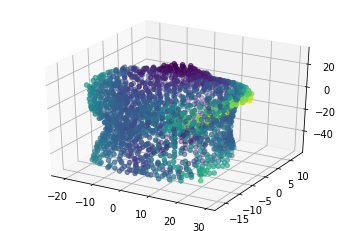

In [ ]:
#Importing the mesh
mesh = df.Mesh('./torso.xml.gz')
#FE space
V = df.FunctionSpace(mesh,'P',1)
#Boundary condition
uD = df.Expression('1 + x[0]*x[0] + 2+x[1]*x[1]', degree=3)
def boundary (x,on_boundary):
  return on_boundary
bc = df.DirichletBC(V, uD, boundary)
#Weak formulation
f = df.Constant(0)
uh = df.TrialFunction(V)
vh = df.TestFunction(V)
a = df.dot(df.grad(uh),df.grad(vh)) * df.dx
F = f*vh *df.dx
#Solution
u = df.Function(V)
df.solve(a==F, u, bc)
df.plot(u)
#Save solution on external file
vtkfile = df.File('/content/drive/MyDrive/Colab Notebooks/Functional analysis and numerics for PDEs/Paraview Solutions/Lab 04/Torso_solution.pvd')
vtkfile << u 

#**Poisson problem with imported mesh and boundary  markers**

$$-\Delta u = f, \quad \text{in } \Omega \\ u = u_D, \quad \text{on } \partial \Omega $$

where:
- the source term is a constant: $f = 0$;

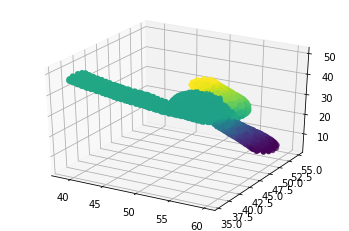

In [ ]:
#Importing the mesh
mesh = df.Mesh('./aneurysm.xml.gz')
#FE space
V = df.FunctionSpace(mesh,'P',1)
#Boundary condition
facet_domains = df.MeshFunction('size_t', mesh, 2, mesh.domains() )
u1 = df.Constant(-1)
u2 = df.Constant(2)
u3 = df.Constant(4)
bc1 = df.DirichletBC(V, u1, facet_domains, 1)
bc2 = df.DirichletBC(V, u2, facet_domains, 2)
bc3 = df.DirichletBC(V, u3, facet_domains, 3)
#Weak formulation
f = df.Constant(0)
uh = df.TrialFunction(V)
vh = df.TestFunction(V)
a = df.dot(df.grad(uh),df.grad(vh)) * df.dx
F = f*vh *df.dx
#Solution
u = df.Function(V)
df.solve(a==F, u, [bc1,bc2,bc3])
df.plot(u)
#Save solution on external file
vtkfile = df.File('/content/drive/MyDrive/Colab Notebooks/Functional analysis and numerics for PDEs/Paraview Solutions/Lab 04/Aneurysm_solution.pvd')
vtkfile << u 